<a href="https://colab.research.google.com/github/karimaahdich/deep-learning-lab/blob/main/Atelier2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: CNN Classifier

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, f1_score

import numpy as np
import time
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

len(train_dataset), len(test_dataset)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 427kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.96MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.08MB/s]


(10000, 10000)

In [3]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model_cnn = CNN_MNIST().to(device)
model_cnn


CNN_MNIST(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

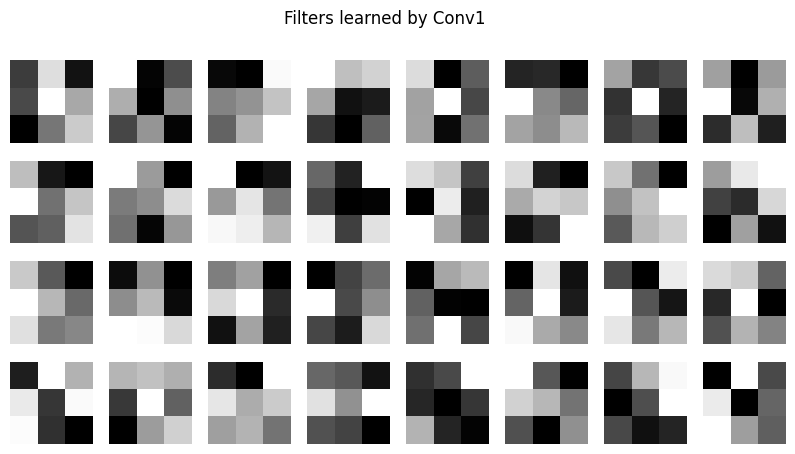

In [4]:
import matplotlib.pyplot as plt

# Get the first convolution layer
first_conv = model_cnn.conv[0]

# Extract weights (shape: 32 filters × 1 channel × 3 × 3)
filters = first_conv.weight.data.cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(filters[i, 0, :, :], cmap="gray")
    plt.axis("off")

plt.suptitle("Filters learned by Conv1")
plt.show()


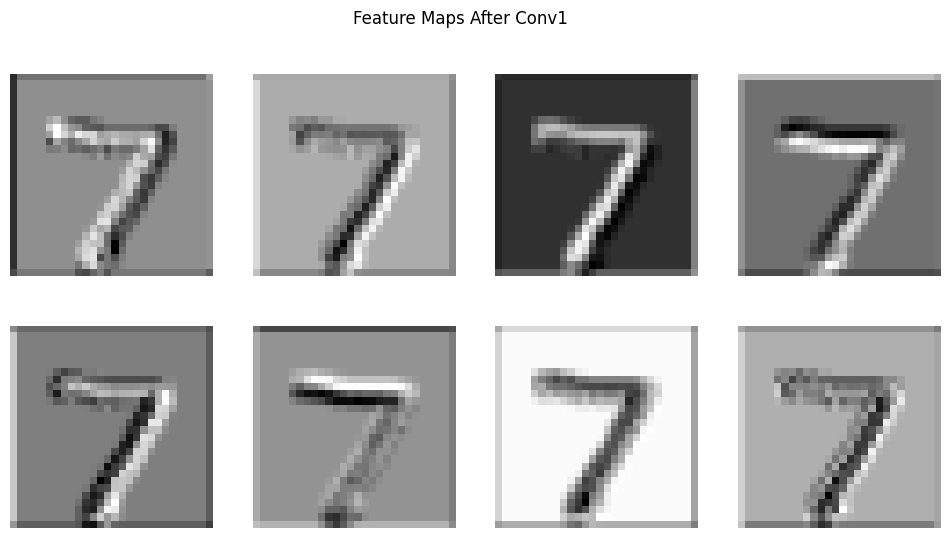

In [5]:
def visualize_feature_maps(model, img):
    model.eval()
    with torch.no_grad():
        x = img.unsqueeze(0).to(device)
        x = model.conv[0](x)  # output of first Conv2d
        feature_maps = x.cpu().numpy()[0]

    plt.figure(figsize=(12, 6))
    for i in range(8):  # show first 8 maps
        plt.subplot(2, 4, i+1)
        plt.imshow(feature_maps[i], cmap="gray")
        plt.axis("off")
    plt.suptitle("Feature Maps After Conv1")
    plt.show()

# Exemple: visualiser une image du dataset
sample_img, _ = test_dataset[0]
visualize_feature_maps(model_cnn, sample_img)


In [6]:
#Train function
def train_model(model, train_loader, test_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, test_losses = [], []
    start = time.time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Test
        model.eval()
        preds, gts, test_loss = [], [], 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                preds.extend(outputs.argmax(1).cpu().numpy())
                gts.extend(labels.cpu().numpy())

        test_losses.append(test_loss / len(test_loader))
        acc = accuracy_score(gts, preds)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_losses[-1]:.4f} - TestAcc: {acc:.4f}")

    total_time = time.time() - start
    return train_losses, test_losses, total_time


In [7]:
#Train CNN
cnn_train_losses, cnn_test_losses, cnn_time = train_model(model_cnn, train_loader, test_loader)

Epoch 1/5 - Loss: 0.5222 - TestAcc: 0.9686
Epoch 2/5 - Loss: 0.1331 - TestAcc: 0.9821
Epoch 3/5 - Loss: 0.0806 - TestAcc: 0.9895
Epoch 4/5 - Loss: 0.0596 - TestAcc: 0.9884
Epoch 5/5 - Loss: 0.0469 - TestAcc: 0.9953


In [8]:
model_cnn.eval()
preds, gts = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model_cnn(imgs)

        preds.extend(outputs.argmax(1).cpu().numpy())
        gts.extend(labels.cpu().numpy())

cnn_acc = accuracy_score(gts, preds)
cnn_f1 = f1_score(gts, preds, average="weighted")

print("CNN Accuracy:", cnn_acc)
print("CNN F1 Score:", cnn_f1)
print("Training Time:", cnn_time, "seconds")


CNN Accuracy: 0.9953
CNN F1 Score: 0.9952968641444729
Training Time: 109.1829161643982 seconds


PART 2 — Faster R-CNN (adapted to MNIST)

In [9]:

!pip install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

# -----------------------------
# 1. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 2. Load MNIST Dataset
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -----------------------------
# 3. ViT Components

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=7, emb_size=64, img_size=28):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)          # [B, emb_size, n_patch_h, n_patch_w]
        x = x.flatten(2)          # [B, emb_size, n_patches]
        x = x.transpose(1,2)      # [B, n_patches, emb_size]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=64, num_heads=4, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, dropout=dropout)

    def forward(self, x):
        x = x.transpose(0,1)  # [n_patches, B, emb_size]
        x, _ = self.mha(x, x, x)
        x = x.transpose(0,1)  # [B, n_patches, emb_size]
        return x

class TransformerBlock(nn.Module):
    def __init__(self, emb_size=64, num_heads=4, ff_hidden=128, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn  = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm2 = nn.LayerNorm(emb_size)
        self.ff    = nn.Sequential(
            nn.Linear(emb_size, ff_hidden),
            nn.GELU(),
            nn.Linear(ff_hidden, emb_size)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

class ViT(nn.Module):
    def __init__(self, in_channels=1, patch_size=7, emb_size=64, img_size=28,
                 num_layers=4, num_heads=4, ff_hidden=128, num_classes=10, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.cls_token = nn.Parameter(torch.zeros(1,1,emb_size))
        self.pos_embed = nn.Parameter(torch.zeros(1,  (img_size//patch_size)**2 + 1, emb_size))
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([
            TransformerBlock(emb_size, num_heads, ff_hidden, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(emb_size)
        self.head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B,-1,-1)  # [B,1,emb_size]
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        cls_out = x[:,0]
        return self.head(cls_out)

# -----------------------------
# 4. Model, Loss, Optimizer

model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# -----------------------------
# 5. Training Loop

epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(train_loader):.4f}")

# -----------------------------
# 6. Evaluation

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100*correct/total:.2f}%")


Using device: cpu
Epoch [1/5] - Loss: 0.9250
Epoch [2/5] - Loss: 0.3558
Epoch [3/5] - Loss: 0.2489
Epoch [4/5] - Loss: 0.1963
Epoch [5/5] - Loss: 0.1690
Test Accuracy: 96.74%
